In [1]:
!python -V

Python 3.10.16


In [ ]:
import os
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse, root_mean_squared_error as rmse
from sklearn.feature_extraction import DictVectorizer

In [2]:
df = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-01.parquet")

print(f'Dataset dimensions -> {df.shape=}')

df.head(3)

Dataset dimensions -> df.shape=(48326, 21)


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee
0,2,2025-01-01 00:03:01,2025-01-01 00:17:12,N,1.0,75,235,1.0,5.93,24.70,...,0.5,6.8,0.0,NaN,1.0,34.00,1.0,1.0,0.0,0.0
1,2,2025-01-01 00:19:59,2025-01-01 00:25:52,N,1.0,166,75,1.0,1.32,8.60,...,0.5,0.0,0.0,NaN,1.0,11.10,2.0,1.0,0.0,0.0
2,2,2025-01-01 00:05:29,2025-01-01 00:07:21,N,5.0,171,73,1.0,0.41,25.55,...,0.0,0.0,0.0,NaN,1.0,26.55,2.0,2.0,0.0,0.0


In [3]:
categorical, numerical = ['PULocationID', 'DOLocationID'], ['trip_distance']


df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]
df[categorical] = df[categorical].astype(str)

df.head(3)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee,duration
0,2,2025-01-01 00:03:01,2025-01-01 00:17:12,N,1.0,75,235,1.0,5.93,24.70,...,6.8,0.0,NaN,1.0,34.00,1.0,1.0,0.0,0.0,14.183333
1,2,2025-01-01 00:19:59,2025-01-01 00:25:52,N,1.0,166,75,1.0,1.32,8.60,...,0.0,0.0,NaN,1.0,11.10,2.0,1.0,0.0,0.0,5.883333
2,2,2025-01-01 00:05:29,2025-01-01 00:07:21,N,5.0,171,73,1.0,0.41,25.55,...,0.0,0.0,NaN,1.0,26.55,2.0,2.0,0.0,0.0,1.866667


In [4]:
records = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(records)
y_train = df['duration'].values

In [5]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
mse_calculated = mse(y_train, y_pred)

print(f'Error calculated --> {mse_calculated:.4f}')

Error calculated --> 44.9474


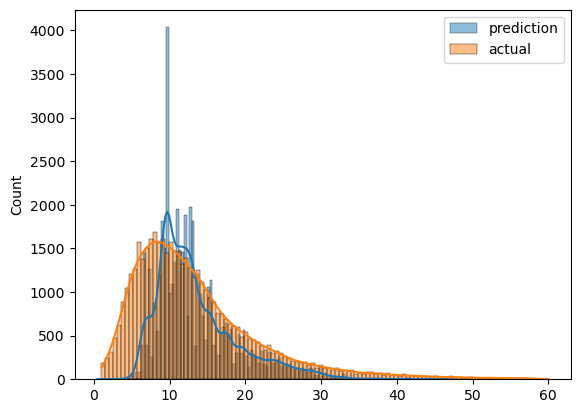

In [6]:
sns.histplot(y_pred, kde=True, label='prediction')
sns.histplot(y_train, kde=True, label='actual')

plt.legend()
plt.show()

In [ ]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_parquet(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df


def data_pipeline(dataset, dv, type='train'):
    dataset['PU_DO'] = dataset['PULocationID'] + '_' + dataset['DOLocationID']
    categorical, numerical = ['PU_DO'], ['trip_distance']

    records = dataset[categorical + numerical].to_dict(orient='records')

    if type == 'train':
        X = dv.fit_transform(records)
    else:
        X = dv.transform(records)

    return X

In [9]:
jan_2025 = 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-01.parquet'
feb_2025 = 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-02.parquet'

df_train = read_dataframe(jan_2025)
print(f'Train Dataset dimensions -> {df_train.shape=}')

df_val = read_dataframe(feb_2025)
print(f'Validation Dataset dimensions -> {df_val.shape=}')

Train Dataset dimensions -> df_train.shape=(43837, 22)
Validation Dataset dimensions -> df_val.shape=(41596, 22)


In [10]:
dv = DictVectorizer()

X_train = data_pipeline(df_train, dv, type='train')
X_val = data_pipeline(df_val, dv, type='val')

y_train = df_train['duration']
y_val = df_val['duration']

In [11]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
mse_calculated = mse(y_val, y_pred)
rmse_calculated = rmse(y_val, y_pred)

print(f'(MSE) Error calculated with Linear Regression --> {mse_calculated:.4f}')
print(f'(RMSE) Error calculated with Linear Regression --> {rmse_calculated:.4f}')

(MSE) Error calculated with Linear Regression --> 16.2088
(RMSE) Error calculated with Linear Regression --> 4.0260


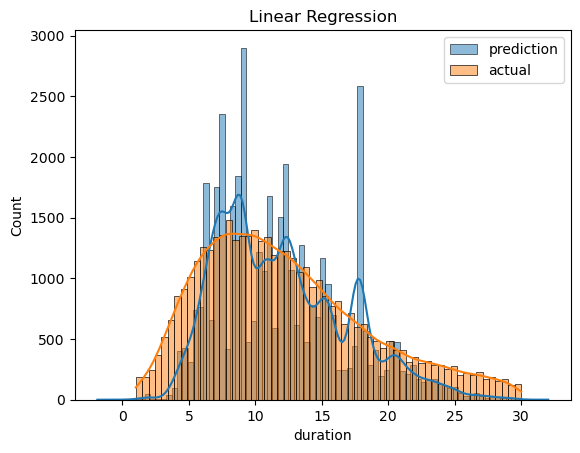

In [12]:
sns.histplot(y_pred, kde=True, label='prediction')
sns.histplot(y_val, kde=True, label='actual')

plt.legend()
plt.title('Linear Regression')
plt.show()

In [13]:
lassoR = Lasso()
lassoR.fit(X_train, y_train)

y_pred = lassoR.predict(X_val)
mse_calculated = mse(y_val, y_pred)
rmse_calculated = rmse(y_val, y_pred)

print(f'(MSE) Error calculated with Lasso Regression --> {mse_calculated:.4f}')
print(f'(RMSE) Error calculated with LLasso Regression --> {rmse_calculated:.4f}')

(MSE) Error calculated with Lasso Regression --> 38.7851
(RMSE) Error calculated with LLasso Regression --> 6.2278


In [15]:
print(np.isnan(y_pred).any(), np.isinf(y_pred).any())

False False


In [16]:
ridgeR = Ridge()
ridgeR.fit(X_train, y_train)

y_pred = ridgeR.predict(X_val)
mse_calculated = mse(y_val, y_pred)
rmse_calculated = rmse(y_val, y_pred)

print(f'(MSE) Error calculated with Ridge Regression --> {mse_calculated:.4f}')
print(f'(RMSE) Error calculated with Ridge Regression --> {rmse_calculated:.4f}')

(MSE) Error calculated with Ridge Regression --> 16.0368
(RMSE) Error calculated with Ridge Regression --> 4.0046


In [17]:
print(np.isnan(y_pred).any(), np.isinf(y_pred).any())

False False


In [24]:
parent_dir = os.path.dirname(os.getcwd())

with open(f'{parent_dir}/models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)